# Summarize and aggregate susceptibility scores across all queries

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
from typing import Dict, List, Set, Union, Tuple
import yaml
from ast import literal_eval

import json
import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import font_manager as fm, pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.53359913.kevidu/ipykernel_175709/3431679233.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pan

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from utils import construct_paths_and_dataset_kwargs

'Bitstream Vera Sans'

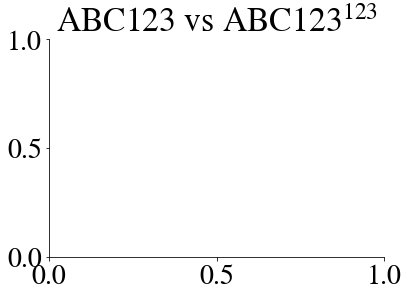

In [53]:
from analysis.mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

In [6]:
##################
### Parameters ###
##################

# Data parameters
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

### Construct dataframes for analysis

In [7]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [8]:
query_ids = list(yago_qec.keys())

In [9]:
analysis_dir = "analysis/summarize/"
os.makedirs(analysis_dir, exist_ok=True)

In [10]:
dataset_names_and_rdps = [("YagoECQ", RAW_DATA_PATH)]
seeds = [11, 12, 13]
model_id_and_quantize_tuples = [("EleutherAI/pythia-6.9b-deduped", False)]
max_contexts = [600]
max_entities = [100]
query_ids = list(yago_qec.keys())
# query_ids = ["http://schema.org/founder"]

ent_selection_fns = [
    "top_entity_uri_degree",
    # "top_entity_namesake_degree",
    # "random_sample",
]

entity_types = json.dumps(
    ["entities", "gpt_fake_entities"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
query_types = json.dumps(
    ["closed", "open"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
context_types = json.dumps(["assertive", "base", "negation"], separators=(",", ":"))

answer_map = dict()
# answer_map = {0: [" No", " no", " NO", "No", "no", "NO"], 1: [" Yes", " yes", " YES", "Yes", "yes", "YES"]}

cap_per_type = False
ablate = False
deduplicate_entities = True
uniform_contexts = True
overwrite = False


def convert_answer_map_to_tokens(
    model_id: str, answer_map: Dict[int, List[str]]
) -> str:
    answer_map_token_ids = dict()
    if answer_map:
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            padding_side="left",
        )

        for k, v in answer_map.items():
            list_of_token_ids: List[List[str]] = tokenizer(v)["input_ids"]
            valid_token_ids = []
            for token_id in list_of_token_ids:
                if len(token_id) == 1:
                    valid_token_ids.append(token_id[0])
                else:
                    print(
                        f"tokenizer tokenized an answer map token into multiple tokens ({token_id}), which is invalid input."
                    )
            answer_map_token_ids[k] = valid_token_ids
        #     answer_map_token_ids = {
        #         k: [x[0] for x in tokenizer(v)["input_ids"] if len(x) == 1],
        #         for k, v in answer_map.items()
        #     }
    res = json.dumps(answer_map_token_ids, separators=(",", ":"))
    print(res)
    return res


df_dict = []
for ds, rdp in dataset_names_and_rdps:
    for seed in seeds:
        for model_id, do_quantize in model_id_and_quantize_tuples:
            answer_map_in_tokens = convert_answer_map_to_tokens(model_id, answer_map)
            for qid in query_ids:
                for mc in max_contexts:
                    for me in max_entities:
                        for es in ent_selection_fns:
                            dict_vals = dict(
                                DATASET_NAME=ds,
                                RAW_DATA_PATH=rdp,
                                SEED=seed,
                                MODEL_ID=model_id,
                                LOAD_IN_8BIT=do_quantize,
                                QUERY_ID=qid,
                                MAX_CONTEXTS=mc,
                                MAX_ENTITIES=me,
                                CAP_PER_TYPE=cap_per_type,
                                ABLATE_OUT_RELEVANT_CONTEXTS=ablate,
                                DEDUPLICATE_ENTITIES=deduplicate_entities,
                                UNIFORM_CONTEXTS=uniform_contexts,
                                ENTITY_SELECTION_FUNC_NAME=es,
                                OVERWRITE=False,
                                ENTITY_TYPES=json.loads(entity_types),
                                QUERY_TYPES=json.loads(query_types),
                                CONTEXT_TYPES=json.loads(context_types),
                                ANSWER_MAP=json.loads(answer_map_in_tokens)
                                if json.loads(answer_map_in_tokens)
                                else None,
                            )
                            (
                                data_dir,
                                input_dir,
                                entities_path,
                                contexts_path,
                                queries_path,
                                answers_path,
                                val_data_path,
                                model_dir,
                                results_dir,
                                val_results_path,
                                mr_results_path,
                                data_id,
                                _,
                                DATASET_KWARGS_IDENTIFIABLE,
                            ) = construct_paths_and_dataset_kwargs(**dict_vals)
                            if os.path.isfile(val_results_path):
                                res = pd.read_csv(
                                    val_results_path,
                                    index_col=0,
                                    converters={
                                        # "contexts": literal_eval,
                                        "entity": literal_eval,
                                    },
                                )
                                closed_qfs = yago_qec[qid]["query_forms"]["closed"]
                                open_qfs = yago_qec[qid]["query_forms"]["open"]

                                res.loc[
                                    res["query_form"].isin(closed_qfs), "query_type"
                                ] = "closed"
                                res.loc[
                                    res["query_form"].isin(open_qfs), "query_type"
                                ] = "open"
                                res.loc[
                                    res["entity"].isin(
                                        [
                                            (x,)
                                            for x in yago_qec[qid]["gpt_fake_entities"]
                                        ]
                                    ),
                                    "entity_type",
                                ] = "gpt_fake_entities"
                                res.loc[
                                    res["entity"].isin(
                                        [(x,) for x in yago_qec[qid]["entities"]]
                                    ),
                                    "entity_type",
                                ] = "entities"
                                res["entity_classes"] = res["q_id"].apply(
                                    lambda x: yago_qec[qid]["entity_types"]
                                )
                                res["entity"] = res["entity"].apply(lambda x: x[0])
                                scores: List[dict] = res[
                                    [
                                        "entity",
                                        "answer",
                                        "query_form",
                                        "entity_type",
                                        "query_type",
                                        "entity_classes",
                                        "susceptibility_score",
                                        "contexts",
                                        "persuasion_scores_kl",
                                    ]
                                ].to_dict("records")
                                df_dict += [{**dict_vals, **d} for d in scores]

{}
{}
{}


In [11]:
# dataset_names_and_rdps = [("YagoECQ", RAW_DATA_PATH)]
# seeds = [8, 9, 10]
# model_id_and_quantize_tuples = [("EleutherAI/pythia-6.9b-deduped", True)]
# max_contexts = [500]
# max_entities = [100]
# query_ids = list(yago_qec.keys())
# # query_ids = ["http://schema.org/founder"]

# ent_selection_fns = [
#     "top_entity_uri_degree",
#     "top_entity_namesake_degree",
#     "random_sample",
# ]

# entity_types = json.dumps(
#     ["entities", "gpt_fake_entities"], separators=(",", ":")
# )  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
# query_types = json.dumps(
#     ["closed", "open"], separators=(",", ":")
# )  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
# context_types = json.dumps(["base"], separators=(",", ":"))

# answer_map = dict()
# # answer_map = {0: [" No", " no", " NO", "No", "no", "NO"], 1: [" Yes", " yes", " YES", "Yes", "yes", "YES"]}

# cap_per_type = False
# ablate = False
# deduplicate_entities = True
# uniform_contexts = True
# overwrite = False


# def convert_answer_map_to_tokens(
#     model_id: str, answer_map: Dict[int, List[str]]
# ) -> str:
#     answer_map_token_ids = dict()
#     if answer_map:
#         tokenizer = AutoTokenizer.from_pretrained(
#             model_id,
#             padding_side="left",
#         )

#         for k, v in answer_map.items():
#             list_of_token_ids: List[List[str]] = tokenizer(v)["input_ids"]
#             valid_token_ids = []
#             for token_id in list_of_token_ids:
#                 if len(token_id) == 1:
#                     valid_token_ids.append(token_id[0])
#                 else:
#                     print(
#                         f"tokenizer tokenized an answer map token into multiple tokens ({token_id}), which is invalid input."
#                     )
#             answer_map_token_ids[k] = valid_token_ids
#         #     answer_map_token_ids = {
#         #         k: [x[0] for x in tokenizer(v)["input_ids"] if len(x) == 1],
#         #         for k, v in answer_map.items()
#         #     }
#     res = json.dumps(answer_map_token_ids, separators=(",", ":"))
#     print(res)
#     return res


# df_dict = []
# for ds, rdp in dataset_names_and_rdps:
#     for seed in seeds:
#         for model_id, do_quantize in model_id_and_quantize_tuples:
#             answer_map_in_tokens = convert_answer_map_to_tokens(model_id, answer_map)
#             for qid in query_ids:
#                 for mc in max_contexts:
#                     for me in max_entities:
#                         for es in ent_selection_fns:
#                             dict_vals = dict(
#                                 DATASET_NAME=ds,
#                                 RAW_DATA_PATH=rdp,
#                                 SEED=seed,
#                                 MODEL_ID=model_id,
#                                 LOAD_IN_8BIT=do_quantize,
#                                 QUERY_ID=qid,
#                                 MAX_CONTEXTS=mc,
#                                 MAX_ENTITIES=me,
#                                 CAP_PER_TYPE=cap_per_type,
#                                 ABLATE_OUT_RELEVANT_CONTEXTS=ablate,
#                                 DEDUPLICATE_ENTITIES=deduplicate_entities,
#                                 UNIFORM_CONTEXTS=uniform_contexts,
#                                 ENTITY_SELECTION_FUNC_NAME=es,
#                                 OVERWRITE=False,
#                                 ENTITY_TYPES=json.loads(entity_types),
#                                 QUERY_TYPES=json.loads(query_types),
#                                 CONTEXT_TYPES=json.loads(context_types),
#                                 ANSWER_MAP=json.loads(answer_map_in_tokens)
#                                 if json.loads(answer_map_in_tokens)
#                                 else None,
#                             )
#                             (
#                                 data_dir,
#                                 input_dir,
#                                 entities_path,
#                                 contexts_path,
#                                 queries_path,
#                                 answers_path,
#                                 val_data_path,
#                                 model_dir,
#                                 results_dir,
#                                 val_results_path,
#                                 mr_results_path,
#                                 data_id,
#                                 _,
#                                 DATASET_KWARGS_IDENTIFIABLE,
#                             ) = construct_paths_and_dataset_kwargs(**dict_vals)
#                             if os.path.isfile(val_results_path):
#                                 res = pd.read_csv(
#                                     val_results_path,
#                                     index_col=0,
#                                     converters={
#                                         # "contexts": literal_eval,
#                                         "entity": literal_eval,
#                                     },
#                                 )
#                                 closed_qfs = yago_qec[qid]["query_forms"]["closed"]
#                                 open_qfs = yago_qec[qid]["query_forms"]["open"]

#                                 res.loc[
#                                     res["query_form"].isin(closed_qfs), "query_type"
#                                 ] = "closed"
#                                 res.loc[
#                                     res["query_form"].isin(open_qfs), "query_type"
#                                 ] = "open"
#                                 res.loc[
#                                     res["entity"].isin(
#                                         [
#                                             (x,)
#                                             for x in yago_qec[qid]["gpt_fake_entities"]
#                                         ]
#                                     ),
#                                     "entity_type",
#                                 ] = "gpt_fake_entities"
#                                 res.loc[
#                                     res["entity"].isin(
#                                         [(x,) for x in yago_qec[qid]["entities"]]
#                                     ),
#                                     "entity_type",
#                                 ] = "entities"
#                                 res["entity_classes"] = res["q_id"].apply(
#                                     lambda x: yago_qec[qid]["entity_types"]
#                                 )
#                                 res["entity"] = res["entity"].apply(lambda x: x[0])
#                                 scores: List[dict] = res[
#                                     [
#                                         "entity",
#                                         "answer",
#                                         "query_form",
#                                         "entity_type",
#                                         "query_type",
#                                         "entity_classes",
#                                         "susceptibility_score",
#                                         "contexts",
#                                         "persuasion_scores_kl",
#                                     ]
#                                 ].to_dict("records")
#                                 df_dict += [{**dict_vals, **d} for d in scores]

In [12]:
scores_df = pd.DataFrame(df_dict)
scores_df.drop(columns=["contexts", "persuasion_scores_kl"]).to_csv(
    os.path.join(analysis_dir, "summarized_scores.csv"), index=False
)
scores_df["ENTITY_TYPES"] = scores_df["ENTITY_TYPES"].apply(lambda x: tuple(x))
scores_df["QUERY_TYPES"] = scores_df["QUERY_TYPES"].apply(lambda x: tuple(x))
scores_df["CONTEXT_TYPES"] = scores_df["CONTEXT_TYPES"].apply(lambda x: tuple(x))
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATASET_NAME                  146000 non-null  object 
 1   RAW_DATA_PATH                 146000 non-null  object 
 2   SEED                          146000 non-null  int64  
 3   MODEL_ID                      146000 non-null  object 
 4   LOAD_IN_8BIT                  146000 non-null  bool   
 5   QUERY_ID                      146000 non-null  object 
 6   MAX_CONTEXTS                  146000 non-null  int64  
 7   MAX_ENTITIES                  146000 non-null  int64  
 8   CAP_PER_TYPE                  146000 non-null  bool   
 9   ABLATE_OUT_RELEVANT_CONTEXTS  146000 non-null  bool   
 10  DEDUPLICATE_ENTITIES          146000 non-null  bool   
 11  UNIFORM_CONTEXTS              146000 non-null  bool   
 12  ENTITY_SELECTION_FUNC_NAME    146000 non-nul

In [13]:
# Get scores df for vesteinn to analyze the diff in sus score against the entity frequency
scores_df_vesteinn = scores_df[(scores_df["SEED"] == 1)][
    ["QUERY_ID", "query_form", "entity_type", "query_type", "susceptibility_score"]
]
scores_df_vesteinn.to_csv(
    os.path.join(analysis_dir, "sus_scores_real_and_fake_ents.csv")
)

## Variance of susceptibility scores

### Across seeds only

In [14]:
(
    scores_df.groupby(["QUERY_ID", "entity", "query_type", "query_form"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)
# Higher variance for open questions because the "A is ..." tends to differ from the "What's the {} of entity?"

,QUERY_ID,entity,query_type,query_form,sus_score_var,sus_score_mean
0,http://schema.org/about,A Christmas Carol,closed,Q: Does {answer} pertain to '{entity}'?\nA:,8.054312e-07,0.046029
1,http://schema.org/about,A Christmas Carol,closed,Q: Is '{entity}' about {answer}?\nA:,7.932709e-07,0.054750
2,http://schema.org/about,A Christmas Carol,open,'{entity}' is about,1.100343e-04,0.734676
3,http://schema.org/about,A Christmas Carol,open,Q: What is '{entity}' about?\nA:,1.468130e-05,0.160696
4,http://schema.org/about,A Very Long Engagement,closed,Q: Does {answer} pertain to '{entity}'?\nA:,6.451503e-08,0.043945
...,...,...,...,...,...,...
29723,reverse-http://yago-knowledge.org/resource/ter...,West Virginia,open,{entity} is the terminus of,1.475124e-05,1.593108
29724,reverse-http://yago-knowledge.org/resource/ter...,Xanthus,closed,Q: Is the terminus of {answer} {entity}?\nA:,1.066223e-06,0.045575
29725,reverse-http://yago-knowledge.org/resource/ter...,Xanthus,closed,Q: Is {entity} the terminus of {answer}?\nA:,1.720010e-06,0.046153
29726,reverse-http://yago-knowledge.org/resource/ter...,Xanthus,open,Q: What is {entity} the terminus of?\nA:,1.158419e-06,0.340399


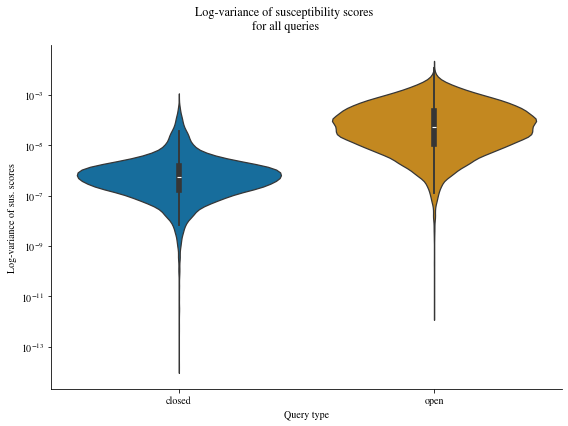

In [15]:
sus_score_var_df = (
    scores_df.groupby(["QUERY_ID", "entity", "query_type", "query_form"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)
sus_score_var_df["log_sus_score_var"] = sus_score_var_df["sus_score_var"].apply(np.log)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    sus_score_var_df,
    y="sus_score_var",
    x="query_type",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
    ax=ax,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of sus. scores")
# ax.set_ylim((-35, -2))
fig.suptitle("Log-variance of susceptibility scores\n for all queries")
plt.tight_layout()

plot_name = f"plot_susscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

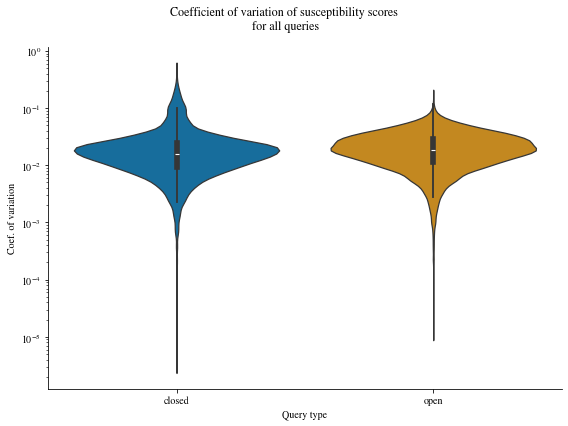

In [16]:
sus_score_var_df["cv"] = (
    sus_score_var_df["sus_score_var"].apply(np.sqrt)
    / sus_score_var_df["sus_score_mean"]
)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    sus_score_var_df,
    y="cv",
    x="query_type",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
    ax=ax,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Coef. of variation")
# ax.set_ylim((-35, -2))
fig.suptitle("Coefficient of variation of susceptibility scores\n for all queries")
plt.tight_layout()

plot_name = f"plot_susscore_cv_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Across seeds and query forms

In [17]:
(
    scores_df.groupby(["QUERY_ID", "entity", "query_type", "SEED"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)

,QUERY_ID,entity,query_type,SEED,sus_score_var,sus_score_mean
0,http://schema.org/about,A Christmas Carol,closed,11,0.000040,0.050006
1,http://schema.org/about,A Christmas Carol,closed,12,0.000038,0.051403
2,http://schema.org/about,A Christmas Carol,closed,13,0.000036,0.049759
3,http://schema.org/about,A Christmas Carol,open,11,0.170597,0.449886
4,http://schema.org/about,A Christmas Carol,open,12,0.164959,0.452240
...,...,...,...,...,...,...
72993,reverse-http://yago-knowledge.org/resource/ter...,Yellowcreek Colony,open,11,1.658669,1.264152
72994,reverse-http://yago-knowledge.org/resource/ter...,Zenith Harbor,closed,13,0.000004,0.041102
72995,reverse-http://yago-knowledge.org/resource/ter...,Zenith Harbor,open,13,1.519512,1.390367
72996,reverse-http://yago-knowledge.org/resource/ter...,Zephyr's Reach,closed,11,0.000007,0.036041


4.506403262686515


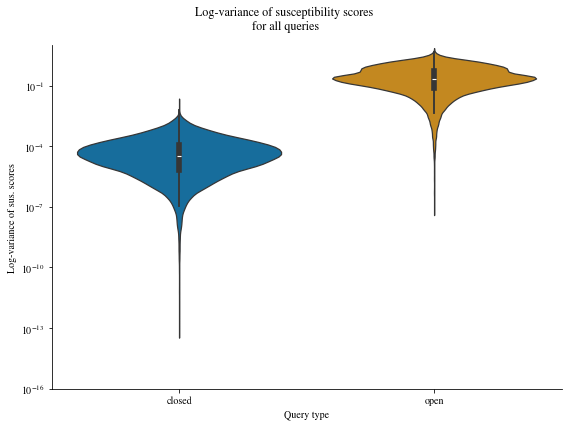

In [18]:
sus_score_var_seed_and_qf_df = (
    scores_df.groupby(["QUERY_ID", "entity", "query_type"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)
sus_score_var_seed_and_qf_df["log_sus_score_var"] = sus_score_var_seed_and_qf_df[
    "sus_score_var"
].apply(np.log)
sus_score_var_seed_and_qf_df["cv"] = (
    sus_score_var_seed_and_qf_df["sus_score_var"].apply(np.sqrt)
    / sus_score_var_seed_and_qf_df["sus_score_mean"]
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    sus_score_var_seed_and_qf_df,
    y="sus_score_var",
    x="query_type",
    hue="query_type",
    order=sorted(sus_score_var_seed_and_qf_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_seed_and_qf_df["query_type"].unique()),
    ax=ax,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of sus. scores")
ax.set_ylim((10**-16, 10**1))

# tcks = ax.get_yticks()
max_y_tick = max(sus_score_var_seed_and_qf_df["sus_score_var"])
# max_y_tick = 10 ** np.ceil(np.log10(max_y_tick))
# tcks[-1] = max_y_tick
# ax.set_yticks(tcks)
print(max_y_tick)

fig.suptitle("Log-variance of susceptibility scores\n for all queries")
plt.tight_layout()

plot_name = (
    f"plot_susscore_variance_across_all_queries_seed_and_queryforms_closed_vs_open"
)
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

## Variance of persuasion scores

### Preprocessing


In [19]:
# Reliability/variance of persuasion scores
scores_df["contexts"] = scores_df["contexts"].apply(literal_eval)

In [20]:
from tqdm import tqdm

tqdm.pandas()
scores_df["persuasion_scores_kl"] = scores_df["persuasion_scores_kl"].progress_apply(
    literal_eval
)

100%|██████████| 146000/146000 [04:40<00:00, 520.96it/s]


In [21]:
scores_df.columns

Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
       'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
       'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
       'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
       'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
       'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
       'susceptibility_score', 'contexts', 'persuasion_scores_kl'],
      dtype='object')

In [22]:
scores_df.head()

,DATASET_NAME,RAW_DATA_PATH,SEED,MODEL_ID,LOAD_IN_8BIT,QUERY_ID,MAX_CONTEXTS,MAX_ENTITIES,CAP_PER_TYPE,ABLATE_OUT_RELEVANT_CONTEXTS,...,ANSWER_MAP,entity,answer,query_form,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores_kl
0,YagoECQ,data/YagoECQ/yago_qec.json,11,EleutherAI/pythia-6.9b-deduped,False,http://schema.org/about,600,100,False,False,...,None,Crime and Punishment,anguish,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.056046,"[Definitely, 'A Christmas Carol' is about Isra...","[0.08909614557093537, 0.08790479019962122, 0.0..."
1,YagoECQ,data/YagoECQ/yago_qec.json,11,EleutherAI/pythia-6.9b-deduped,False,http://schema.org/about,600,100,False,False,...,None,Stranger Things,monster,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.056991,"[Definitely, 'A Christmas Carol' is about Isra...","[0.04681102001718983, 0.05776143042656055, 0.0..."
2,YagoECQ,data/YagoECQ/yago_qec.json,11,EleutherAI/pythia-6.9b-deduped,False,http://schema.org/about,600,100,False,False,...,None,Sleeping Beauty,prostitution,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.050751,"[Definitely, 'A Christmas Carol' is about Isra...","[0.0612264635705814, 0.05662540952670466, 0.04..."
3,YagoECQ,data/YagoECQ/yago_qec.json,11,EleutherAI/pythia-6.9b-deduped,False,http://schema.org/about,600,100,False,False,...,None,Indiana Jones and the Kingdom of the Crystal S...,Cold War,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.065111,"[Definitely, 'A Christmas Carol' is about Isra...","[0.04418715021247012, 0.08924007649793946, 0.0..."
4,YagoECQ,data/YagoECQ/yago_qec.json,11,EleutherAI/pythia-6.9b-deduped,False,http://schema.org/about,600,100,False,False,...,None,A Christmas Carol,time travel,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.054491,"[Definitely, 'A Christmas Carol' is about Isra...","[0.04311509848836577, 0.06601597385816815, 0.0..."


In [23]:
from functools import reduce

# Define a custom aggregation function for intersection
def intersection_aggregate(x):
    # Take the intersection of all sets in the group
    return reduce(lambda a, b: set(a).intersection(set(b)), x)

In [24]:
# Function to filter rows
def filter_rows_by_unique_values(dataframe, column_name, unique_count):
    # Group by the specified column and filter
    filtered_df = dataframe.groupby(column_name).filter(
        lambda x: x["SEED"].nunique() == unique_count
    )
    return filtered_df


# Applying the function
filtered_df = filter_rows_by_unique_values(
    scores_df, ["QUERY_ID", "entity", "query_form", "query_type"], 3
)
filtered_df["contexts"] = filtered_df["contexts"].progress_apply(tuple)
filtered_df["persuasion_scores_kl"] = filtered_df[
    "persuasion_scores_kl"
].progress_apply(tuple)
filtered_df["entity_classes"] = filtered_df["entity_classes"].progress_apply(tuple)
filtered_df = filtered_df.drop_duplicates()

100%|██████████| 74224/74224 [00:00<00:00, 1240572.79it/s]


In [25]:
set(
    filtered_df[["QUERY_ID", "entity", "query_form", "query_type"]].value_counts()
)  # this should be just 3

{3}

In [26]:
overlapping_contexts_df = (
    filtered_df.groupby(["QUERY_ID", "entity"]).agg(
        shared_contexts=("contexts", intersection_aggregate)
    )
    # .to_frame()
    .reset_index()
)
overlapping_contexts_df = overlapping_contexts_df[
    overlapping_contexts_df["shared_contexts"] != set()
]
overlapping_contexts_df["shared_contexts"] = overlapping_contexts_df[
    "shared_contexts"
].progress_apply(tuple)
overlapping_contexts_df

100%|██████████| 1022/1022 [00:00<00:00, 450744.34it/s]


,QUERY_ID,entity,shared_contexts
0,http://schema.org/about,A Christmas Carol,"(Definitely, 'Moulin Rouge!' is about World Wa..."
1,http://schema.org/about,A Very Long Engagement,"(Definitely, 'Moulin Rouge!' is about World Wa..."
2,http://schema.org/about,Abrasion,"(Definitely, 'Moulin Rouge!' is about World Wa..."
3,http://schema.org/about,Air Force One,"(Definitely, 'Moulin Rouge!' is about World Wa..."
4,http://schema.org/about,Anna and the King,"(Definitely, 'Moulin Rouge!' is about World Wa..."
...,...,...,...
5666,reverse-http://yago-knowledge.org/resource/con...,red deer,(A/an Coleoptera would not be consumed by a/an...
5667,reverse-http://yago-knowledge.org/resource/con...,red fox,(A/an Coleoptera would not be consumed by a/an...
5668,reverse-http://yago-knowledge.org/resource/con...,roe deer,(A/an Coleoptera would not be consumed by a/an...
5669,reverse-http://yago-knowledge.org/resource/con...,squirrel,(A/an Coleoptera would not be consumed by a/an...


In [27]:
overlapping_contexts_filtered_df = overlapping_contexts_df.merge(
    filtered_df, on=["QUERY_ID", "entity"], how="inner"
)
overlapping_contexts_filtered_df = overlapping_contexts_filtered_df.loc[
    :, overlapping_contexts_filtered_df.nunique() > 1
]

In [28]:
exploded_overlapping_contexts_filtered_df = overlapping_contexts_filtered_df.explode(
    "shared_contexts"
)
set(
    exploded_overlapping_contexts_filtered_df[
        ["QUERY_ID", "entity", "shared_contexts", "query_form"]
    ].value_counts()
)  # should just be {3} still

{3}

In [29]:
exploded_overlapping_contexts_filtered_df

,QUERY_ID,entity,shared_contexts,SEED,answer,query_form,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores_kl
0,http://schema.org/about,A Christmas Carol,"Definitely, 'Moulin Rouge!' is about World War...",11,time travel,Q: Is '{entity}' about {answer}?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.054491,"(Definitely, 'A Christmas Carol' is about Isra...","(0.04311509848836577, 0.06601597385816815, 0.0..."
1,http://schema.org/about,A Christmas Carol,"Definitely, 'Moulin Rouge!' is about World War...",11,time travel,Q: Does {answer} pertain to '{entity}'?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.045521,"(Definitely, 'A Christmas Carol' is about Isra...","(0.04268873787680913, 0.08449497569553947, 0.0..."
2,http://schema.org/about,A Christmas Carol,"Definitely, 'Moulin Rouge!' is about World War...",11,time travel,Q: What is '{entity}' about?\nA:,entities,open,"(http://schema.org/CreativeWork, http://schema...",0.157827,"(Definitely, 'A Christmas Carol' is about Isra...","(0.16781893992249589, 0.28933356941870436, 0.5..."
3,http://schema.org/about,A Christmas Carol,"Definitely, 'Moulin Rouge!' is about World War...",11,time travel,'{entity}' is about,entities,open,"(http://schema.org/CreativeWork, http://schema...",0.741945,"(Definitely, 'A Christmas Carol' is about Isra...","(0.793526334025331, 0.552175025317692, 1.10570..."
4,http://schema.org/about,A Christmas Carol,"Definitely, 'Moulin Rouge!' is about World War...",12,time travel,Q: Is '{entity}' about {answer}?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.055741,"(Definitely, 'A Christmas Carol' is about rura...","(0.08180225040264243, 0.04772013256570502, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
12259,reverse-http://yago-knowledge.org/resource/con...,water buffalo,A/an Coleoptera would not be consumed by a/an ...,12,Malayan tiger,A/an {entity} would be consumed by a/an,entities,open,"(http://schema.org/Taxon,)",1.221461,"(Definitely, a/an Abyssopetal deep would be co...","(0.679041709564037, 1.170572065135365, 1.11601..."
12260,reverse-http://yago-knowledge.org/resource/con...,water buffalo,A/an Coleoptera would not be consumed by a/an ...,13,Malayan tiger,Q: Does a/an {answer} consume a/an {entity}?\nA:,entities,closed,"(http://schema.org/Taxon,)",0.048886,"(Definitely, a/an Alces alces would be consume...","(0.07670824093307348, 0.09981663215609866, 0.0..."
12261,reverse-http://yago-knowledge.org/resource/con...,water buffalo,A/an Coleoptera would not be consumed by a/an ...,13,Malayan tiger,Q: Is a/an {entity} something a/an {answer} wo...,entities,closed,"(http://schema.org/Taxon,)",0.048067,"(Definitely, a/an Alces alces would be consume...","(0.08667487811055434, 0.07235885675011007, 0.0..."
12262,reverse-http://yago-knowledge.org/resource/con...,water buffalo,A/an Coleoptera would not be consumed by a/an ...,13,Malayan tiger,Q: What would consume a/an {entity}?\nA:,entities,open,"(http://schema.org/Taxon,)",0.106059,"(Definitely, a/an Alces alces would be consume...","(0.2928743350693169, 0.15561105944538992, 0.10..."


In [30]:
row = exploded_overlapping_contexts_filtered_df.iloc[0]


def get_p_score_for_shared_context(row: pd.Series):
    shared_context_ind = list(row["contexts"]).index(row["shared_contexts"])
    p_score_for_shared_context = row["persuasion_scores_kl"][shared_context_ind]
    return p_score_for_shared_context

In [31]:
exploded_overlapping_contexts_filtered_df[
    "p_score"
] = exploded_overlapping_contexts_filtered_df.progress_apply(
    get_p_score_for_shared_context, axis=1
)

100%|██████████| 286224/286224 [00:04<00:00, 63990.33it/s]


### Across seeds only

In [32]:
var_pscore_df = (
    exploded_overlapping_contexts_filtered_df.groupby(
        ["QUERY_ID", "entity", "query_form", "query_type", "shared_contexts"]
    )
    .agg(var_p_score=("p_score", "var"), mean_p_score=("p_score", "mean"))
    .reset_index()
)
var_pscore_df["log_var_p_score"] = var_pscore_df["var_p_score"].progress_apply(np.log)
var_pscore_df["cv"] = (
    var_pscore_df["var_p_score"].apply(np.sqrt) / var_pscore_df["mean_p_score"]
)

100%|██████████| 95408/95408 [00:00<00:00, 660562.62it/s]


In [33]:
var_pscore_df.sort_values(by=["var_p_score"], ascending=False).head(3)

,QUERY_ID,entity,query_form,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
39610,http://schema.org/locationCreated,Tie Me Up! Tie Me Down!,{entity} was created in,open,"Definitely, Tie Me Up! Tie Me Down! was create...",0.067557,4.061047,-2.694782,0.064003
30785,http://schema.org/knowsLanguage,Sam Shepard,{entity} knows the language,open,"Definitely, Volusian knows the language Polish.\n",0.023112,2.096545,-3.767411,0.072513
25085,http://schema.org/knowsLanguage,Joe Lieberman,{entity} knows the language,open,"Definitely, Volusian knows the language Polish.\n",0.019226,2.424494,-3.951482,0.057191


In [34]:
var_pscore_df.sort_values(by=["cv"], ascending=False)

,QUERY_ID,entity,query_form,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
78396,http://yago-knowledge.org/resource/academicDegree,Antonia Syson,Q: Was the academic degree of {answer} ever aw...,closed,An academic degree held by Eric Betzig is not ...,1.698424e-04,0.021177,-8.680639,0.615410
78393,http://yago-knowledge.org/resource/academicDegree,Antonia Syson,Q: Was the academic degree of {answer} ever aw...,closed,An academic degree held by David Graeber is no...,2.199986e-04,0.024335,-8.421889,0.609509
11339,http://schema.org/inLanguage,Opera,Q: Is {answer} the language used in '{entity}'...,closed,'Momotarō' is in the language English.\n,9.412664e-05,0.016554,-9.270869,0.586087
11242,http://schema.org/inLanguage,Opera,Q: Is '{entity}' in the {answer} language?\nA:,closed,'Opera' is not in the language English.,6.063732e-04,0.042226,-7.408015,0.583165
75073,http://schema.org/officialLanguage,Belgium,Q: Is {entity}'s official language {answer}?\nA:,closed,The official language of South Africa is not F...,1.139160e-03,0.058777,-6.777464,0.574234
...,...,...,...,...,...,...,...,...,...
80220,http://yago-knowledge.org/resource/academicDegree,Ernest Rutherford,An academic degree held by {entity} is,open,An academic degree held by Abraham Maslow is n...,3.703435e-08,1.074754,-17.111420,0.000179
77040,http://schema.org/recordLabel,The Band,Q: Does {answer} serve as {entity}'s record la...,closed,A-ha's record label is not MCA Inc..,1.822824e-11,0.024013,-24.728049,0.000178
1360,http://schema.org/inLanguage,Bayonetta,Q: Is '{entity}' in the {answer} language?\nA:,closed,'The Tales of Beedle the Bard' is not in the l...,3.272354e-11,0.036257,-24.142926,0.000158
29809,http://schema.org/knowsLanguage,Richard Parkes Bonington,Q: What language does {entity} know?\nA:,open,"Definitely, Moses Odion Dickson knows the lang...",8.025621e-10,0.206540,-20.943212,0.000137


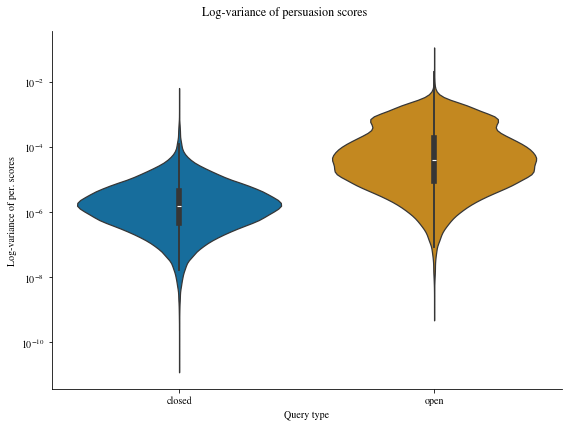

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=var_pscore_df,
    x="query_type",
    y="var_p_score",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of per. scores")
fig.suptitle("Log-variance of persuasion scores")
plt.tight_layout()

plot_name = f"plot_persuasionscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

0.06755710682216294


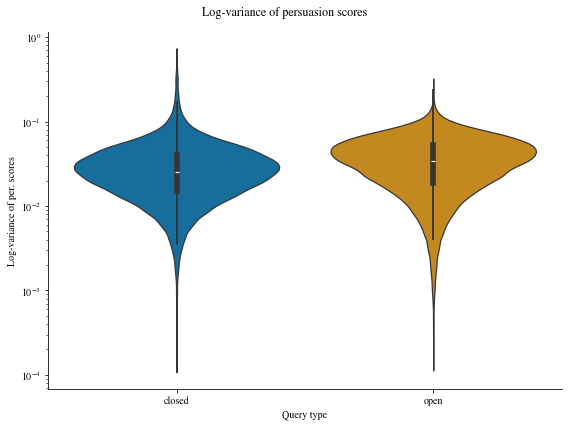

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=var_pscore_df,
    x="query_type",
    y="cv",
    hue="query_type",
    order=sorted(var_pscore_df["query_type"].unique()),
    hue_order=sorted(var_pscore_df["query_type"].unique()),
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of per. scores")
fig.suptitle("Log-variance of persuasion scores")
plt.tight_layout()

plot_name = f"plot_persuasionscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
print(max(var_pscore_df["var_p_score"]))

### Across seeds and query forms

In [37]:
var_pscore_seed_and_qf_df = (
    exploded_overlapping_contexts_filtered_df.groupby(
        ["QUERY_ID", "entity", "query_type", "shared_contexts"]
    )
    .agg(var_p_score=("p_score", "var"), mean_p_score=("p_score", "mean"))
    .reset_index()
)
var_pscore_seed_and_qf_df["log_var_p_score"] = var_pscore_seed_and_qf_df[
    "var_p_score"
].progress_apply(np.log)

var_pscore_seed_and_qf_df["cv"] = (
    var_pscore_seed_and_qf_df["var_p_score"].apply(np.sqrt)
    / var_pscore_seed_and_qf_df["mean_p_score"]
)

var_pscore_seed_and_qf_df

100%|██████████| 47704/47704 [00:00<00:00, 668867.68it/s]


,QUERY_ID,entity,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
0,http://schema.org/about,A Christmas Carol,closed,"Definitely, 'Moulin Rouge!' is about World War...",0.000015,0.065382,-11.109192,0.059185
1,http://schema.org/about,A Christmas Carol,open,"Definitely, 'Moulin Rouge!' is about World War...",0.119810,0.415513,-2.121852,0.833031
2,http://schema.org/about,A Very Long Engagement,closed,"Definitely, 'Moulin Rouge!' is about World War...",0.000020,0.057305,-10.796970,0.078936
3,http://schema.org/about,A Very Long Engagement,open,"Definitely, 'Moulin Rouge!' is about World War...",0.197172,0.529707,-1.623677,0.838276
4,http://schema.org/about,Abrasion,closed,"Definitely, 'Moulin Rouge!' is about World War...",0.000108,0.072548,-9.137431,0.142957
...,...,...,...,...,...,...,...,...
47699,reverse-http://yago-knowledge.org/resource/con...,roe deer,open,A/an Coleoptera would not be consumed by a/an ...,0.339142,0.635333,-1.081336,0.916620
47700,reverse-http://yago-knowledge.org/resource/con...,squirrel,closed,A/an Coleoptera would not be consumed by a/an ...,0.000044,0.043705,-10.021993,0.152483
47701,reverse-http://yago-knowledge.org/resource/con...,squirrel,open,A/an Coleoptera would not be consumed by a/an ...,0.269726,0.515898,-1.310348,1.006695
47702,reverse-http://yago-knowledge.org/resource/con...,water buffalo,closed,A/an Coleoptera would not be consumed by a/an ...,0.000004,0.036833,-12.541262,0.051340


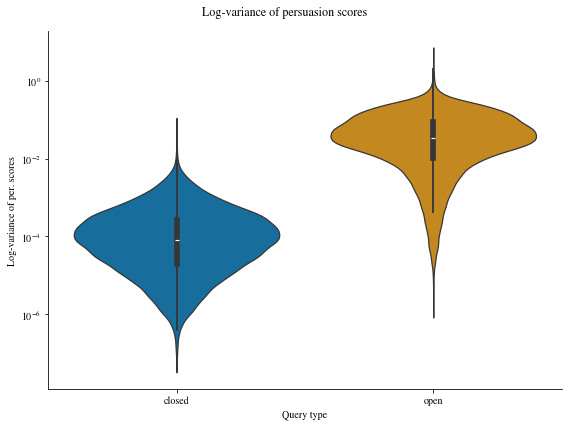

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=var_pscore_seed_and_qf_df,
    x="query_type",
    y="var_p_score",
    hue="query_type",
    order=sorted(var_pscore_seed_and_qf_df["query_type"].unique()),
    hue_order=sorted(var_pscore_seed_and_qf_df["query_type"].unique()),
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of per. scores")
fig.suptitle("Log-variance of persuasion scores")
plt.tight_layout()

plot_name = (
    f"plot_persuasionscore_variance_across_all_queries_seed_and_qf_closed_vs_open"
)
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### One plot

In [39]:
var_pscore_df["var"] = var_pscore_df["var_p_score"]
var_pscore_df["log_var"] = var_pscore_df["log_var_p_score"]
var_pscore_df["score_type"] = "p_score"
var_pscore_df.head(1)

,QUERY_ID,entity,query_form,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv,var,log_var,score_type
0,http://schema.org/about,A Christmas Carol,'{entity}' is about,open,"Definitely, 'Moulin Rouge!' is about World War...",0.001125,0.730862,-6.790171,0.045888,0.001125,-6.790171,p_score


In [40]:
sus_score_var_df["var"] = sus_score_var_df["sus_score_var"]
sus_score_var_df["log_var"] = sus_score_var_df["log_sus_score_var"]
sus_score_var_df["score_type"] = "sus_score"
sus_score_var_df.head(1)

,QUERY_ID,entity,query_type,query_form,sus_score_var,sus_score_mean,log_sus_score_var,cv,var,log_var,score_type
0,http://schema.org/about,A Christmas Carol,closed,Q: Does {answer} pertain to '{entity}'?\nA:,8.054312e-07,0.046029,-14.031888,0.019498,8.054312e-07,-14.031888,sus_score


In [41]:
shared_cols = list(set(sus_score_var_df.columns).intersection(var_pscore_df.columns))
combined_df = pd.concat(
    [sus_score_var_df[shared_cols], var_pscore_df[shared_cols]], axis=0
)
combined_df.head(1)

,QUERY_ID,log_var,var,query_type,score_type,query_form,cv,entity
0,http://schema.org/about,-14.031888,8.054312e-07,closed,sus_score,Q: Does {answer} pertain to '{entity}'?\nA:,0.019498,A Christmas Carol


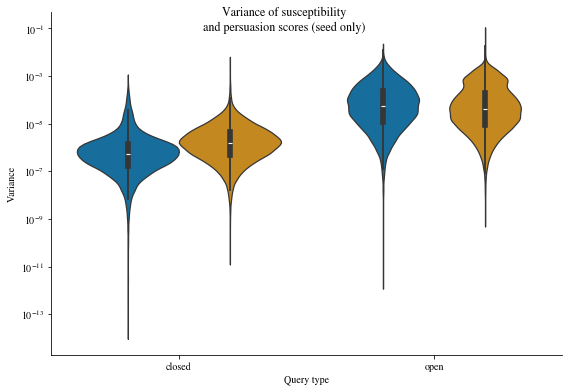

In [42]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_df,
    x="query_type",
    y="var",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Variance")
fig.suptitle("Variance of susceptibility\nand persuasion scores (seed only)", y=0.9)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

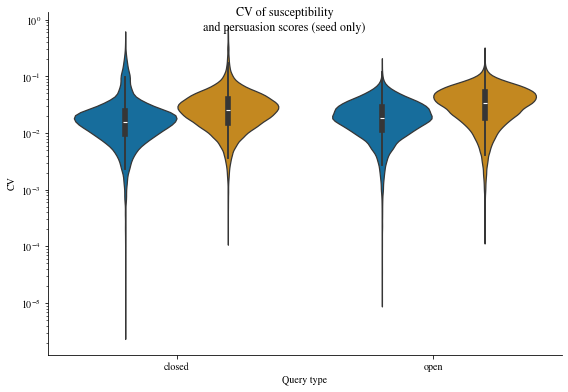

In [43]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_df,
    x="query_type",
    y="cv",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("CV")
fig.suptitle("CV of susceptibility\nand persuasion scores (seed only)", y=0.9)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [44]:
var_pscore_seed_and_qf_df

,QUERY_ID,entity,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
0,http://schema.org/about,A Christmas Carol,closed,"Definitely, 'Moulin Rouge!' is about World War...",0.000015,0.065382,-11.109192,0.059185
1,http://schema.org/about,A Christmas Carol,open,"Definitely, 'Moulin Rouge!' is about World War...",0.119810,0.415513,-2.121852,0.833031
2,http://schema.org/about,A Very Long Engagement,closed,"Definitely, 'Moulin Rouge!' is about World War...",0.000020,0.057305,-10.796970,0.078936
3,http://schema.org/about,A Very Long Engagement,open,"Definitely, 'Moulin Rouge!' is about World War...",0.197172,0.529707,-1.623677,0.838276
4,http://schema.org/about,Abrasion,closed,"Definitely, 'Moulin Rouge!' is about World War...",0.000108,0.072548,-9.137431,0.142957
...,...,...,...,...,...,...,...,...
47699,reverse-http://yago-knowledge.org/resource/con...,roe deer,open,A/an Coleoptera would not be consumed by a/an ...,0.339142,0.635333,-1.081336,0.916620
47700,reverse-http://yago-knowledge.org/resource/con...,squirrel,closed,A/an Coleoptera would not be consumed by a/an ...,0.000044,0.043705,-10.021993,0.152483
47701,reverse-http://yago-knowledge.org/resource/con...,squirrel,open,A/an Coleoptera would not be consumed by a/an ...,0.269726,0.515898,-1.310348,1.006695
47702,reverse-http://yago-knowledge.org/resource/con...,water buffalo,closed,A/an Coleoptera would not be consumed by a/an ...,0.000004,0.036833,-12.541262,0.051340


In [45]:
var_pscore_seed_and_qf_df["var"] = var_pscore_seed_and_qf_df["var_p_score"]
# var_pscore_seed_and_qf_df["log_var"] = var_pscore_seed_and_qf_df["log_var_p_score"]
var_pscore_seed_and_qf_df["score_type"] = "p_score"
var_pscore_seed_and_qf_df.head(1)

sus_score_var_seed_and_qf_df["var"] = sus_score_var_seed_and_qf_df["sus_score_var"]
# sus_score_var_seed_and_qf_df["log_var"] = sus_score_var_seed_and_qf_df[
#     "log_sus_score_var"
# ]
sus_score_var_seed_and_qf_df["score_type"] = "sus_score"
sus_score_var_seed_and_qf_df.head(1)

shared_cols = list(
    set(sus_score_var_seed_and_qf_df.columns).intersection(
        var_pscore_seed_and_qf_df.columns
    )
)
combined_seed_and_qf_df = pd.concat(
    [sus_score_var_seed_and_qf_df[shared_cols], var_pscore_seed_and_qf_df[shared_cols]],
    axis=0,
)
combined_seed_and_qf_df.head(1)

,QUERY_ID,var,query_type,score_type,cv,entity
0,http://schema.org/about,0.000023,closed,sus_score,0.096116,A Christmas Carol


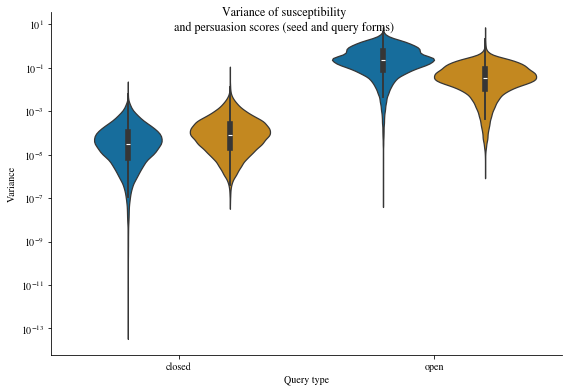

In [46]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_seed_and_qf_df,
    x="query_type",
    y="var",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_seed_and_qf_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Variance")
fig.suptitle(
    "Variance of susceptibility\nand persuasion scores (seed and query forms)", y=0.9
)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

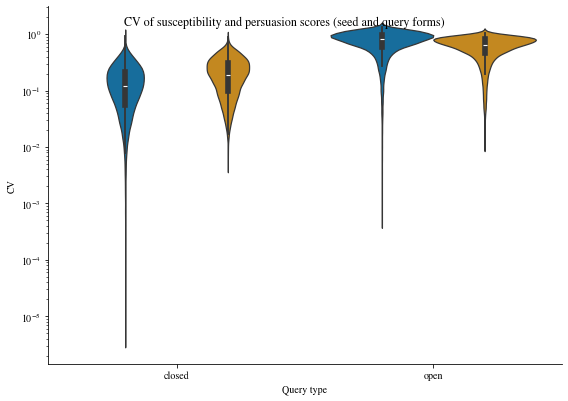

In [47]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_seed_and_qf_df,
    x="query_type",
    y="cv",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_seed_and_qf_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("CV")
fig.suptitle("CV of susceptibility and persuasion scores (seed and query forms)", y=0.9)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

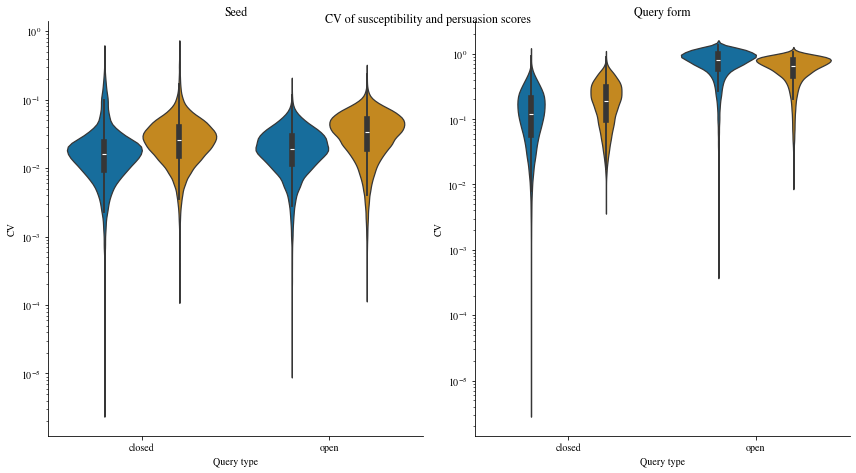

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
var_axes_dict = {"Seed": combined_df, "Query form": combined_seed_and_qf_df}
for i, (name, df) in enumerate(var_axes_dict.items()):
    ax = axes[i]
    sns.violinplot(
        data=df,
        x="query_type",
        y="cv",
        # y="log_var",
        hue="score_type",
        dodge=True,
        order=sorted(combined_seed_and_qf_df["query_type"].unique()),
        hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
        legend=None,
        log_scale=True,
        ax=ax,
    )
    ax.set_xlabel("Query type")
    ax.set_ylabel("CV")
    ax.set_title(name)

fig.suptitle(
    "CV of susceptibility and persuasion scores",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_cv_all_scores_qt_varaxes"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

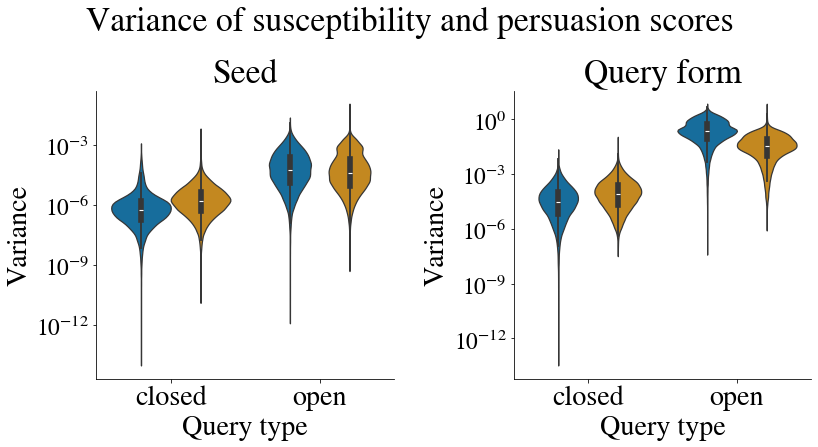

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
var_axes_dict = {"Seed": combined_df, "Query form": combined_seed_and_qf_df}
for i, (name, df) in enumerate(var_axes_dict.items()):
    ax = axes[i]
    sns.violinplot(
        data=df,
        x="query_type",
        y="var",
        # y="log_var",
        hue="score_type",
        dodge=True,
        order=sorted(combined_seed_and_qf_df["query_type"].unique()),
        hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
        legend=None,
        log_scale=True,
        ax=ax,
    )
    ax.set_xlabel("Query type")
    ax.set_ylabel("Variance")
    ax.tick_params(axis="y", which="major", labelsize="small")
    ax.set_title(name)

fig.suptitle(
    "Variance of susceptibility and persuasion scores",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_var_all_scores_qt_varaxes"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Scratch

In [50]:
# SUS scores
qid = "http://schema.org/lyricist"
query_form = scores_df[scores_df["QUERY_ID"] == qid]["query_form"].unique()[0]
qid_df = scores_df[(scores_df["QUERY_ID"] == qid)][
    ["SEED", "entity", "query_form", "susceptibility_score"]
]

qid_qf_df = qid_df[qid_df["query_form"] == query_form]
qid_qf_df

,SEED,entity,query_form,susceptibility_score
15600,11,The Internationale,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.047828
15601,11,God Save the Queen,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.066860
15602,11,Blue Monday,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.059546
15603,11,High Hopes,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.082112
15604,11,Il Canto degli Italiani,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.044772
...,...,...,...,...
112895,13,The Pilgrim’s Refrain,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.071764
112896,13,The Valkyrie’s Respite,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.084638
112897,13,GlowGear Reflective Gear,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.076815
112898,13,Mosaic of the Monsoon,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.067795


In [51]:
qid_df.groupby(["entity", "query_form"]).agg({"susceptibility_score": "var"}).dropna()

susceptibility_score
entity              query_form                                                              
Across the Universe A lyricist for '{entity}' is a                              8.754192e-04
                    Q: Does '{entity}' credit {answer} as a lyricis...          1.590011e-08
                    Q: Is {answer} a lyricist for '{entity}'?\nA:               4.590331e-07
                    Q: Who is a lyricist for '{entity}'?\nA:                    6.372653e-06
Amazing Grace       A lyricist for '{entity}' is a                              8.384900e-04
...                                                                                      ...
Wish You Were Here  Q: Who is a lyricist for '{entity}'?\nA:                    4.744360e-05
Your Song           A lyricist for '{entity}' is a                              1.654946e-03
                    Q: Does '{entity}' credit {answer} as a lyricis...          1.747937e-07
                    Q: Is {answer} a lyricist for '{entity}'?\nA:               8.065717e-07
                    Q: Who is a lyricist for '{entity}'?\nA:                    7.344446e-05

[232 rows x 1 columns]

In [52]:
# Persuasion scores
overlapping_contexts_filtered_df[
    (
        overlapping_contexts_filtered_df["QUERY_ID"]
        == "http://schema.org/contentLocation"
    )
    & (overlapping_contexts_filtered_df["entity"] == "A Midsummer Night's Dream")
    & (overlapping_contexts_filtered_df["query_form"] == "'{entity}' takes place in")
]["contexts"]

Series([], Name: contexts, dtype: object)